In [7]:
from math import log10
from math import sqrt
import time

In [8]:
def snr(noisy,denoised):
  temp=noisy;
  y=denoised;
  num=0;
  den=0;
  for i in range(len(temp)):
    den=den+(y[i]-temp[i])*(y[i]-temp[i])
  for i in range(len(temp)):
    num=num+temp[i]*temp[i]
  return 20*log10(sqrt(num)/sqrt(den))

(999,)


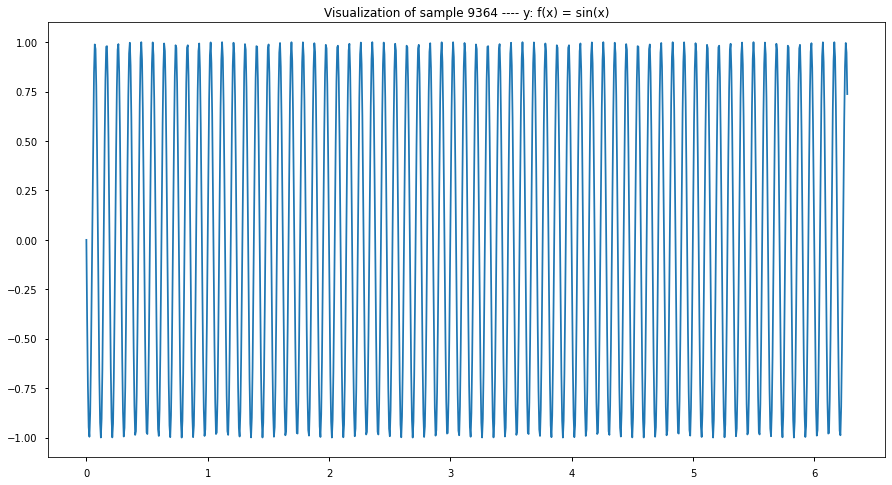

In [9]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(52102)

%matplotlib inline
plt.style.use(['seaborn-notebook'])
plt.rcParams.update({
    "font.serif": ["cm"],
    "mathtext.fontset": "cm",
    "figure.figsize": (15, 8),
    "axes.labelsize": 15,
    "font.size": 8})

# Sample configuration
num_samples = 10000

# Intrasample configuration
num_elements = 2*np.pi
interval_per_element = (2*np.pi)/1000
total_num_elements = int(num_elements / interval_per_element)
#starting_point = int(0 - 0.5*total_num_elements)
starting_point=0

# Other configuration
num_samples_visualize = 1

# Containers for samples and subsamples
samples = []
xs = []
ys = []

# Range 10Hz - 90Hz
LowFreq = 10
HighFreq = 90
Range = LowFreq - HighFreq

# Generate samples
for j in range(0, num_samples):
  temp1 = j % Range + LowFreq
  # Report progress
  #if j % 100 == 0:
    #print(j)
  # Generate wave
  for i in range(starting_point, total_num_elements):
    x_val = i*(interval_per_element) 
    y_val = np.sin(x_val * temp1)
    xs.append(x_val)
    ys.append(y_val)
  # Append wave to samples
  samples.append((xs, ys))
  # Clear subsample containers for next sample
  xs = []
  ys = []

# Input shape
print(np.shape(np.array(samples[0][0])))
  
# Save data to file for re-use
np.save('./signal_waves_medium.npy', samples)

# Visualize a few random samples
for i in range(0, num_samples_visualize):
  random_index = np.random.randint(0, len(samples)-1)
  x_axis, y_axis = samples[random_index]
  plt.plot(x_axis, y_axis)
  plt.title(f'Visualization of sample {random_index} ---- y: f(x) = sin(x)')
  plt.show()

8.251398409503372


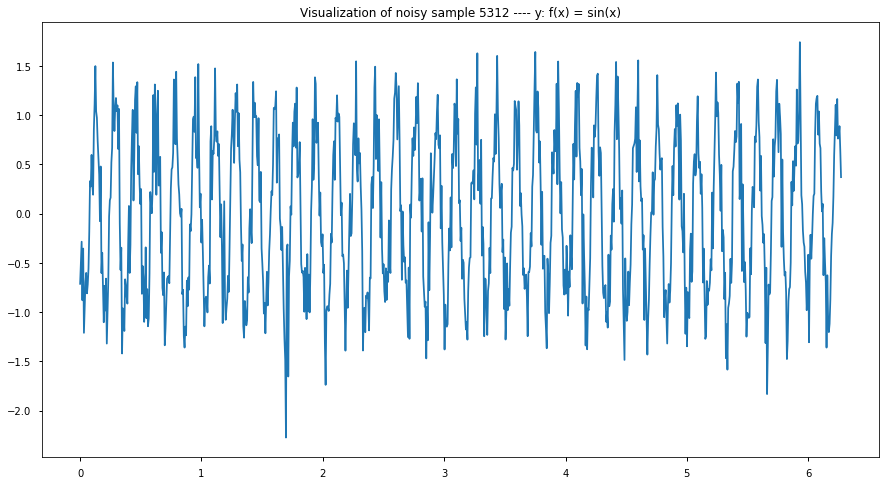

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample configuration
num_samples_visualize = 1
noise_factor = 0.3

# Load data
data = np.load('./signal_waves_medium.npy')
x_val, y_val = data[:,0], data[:,1]

# Add noise to data
noisy_samples = []
for i in range(0, len(x_val)):
  #if i % 100 == 0:
    #print(i)
  pure = np.array(y_val[i])
  noise = np.random.normal(0, 1, pure.shape)
  signal = pure + noise_factor * noise
  noisy_samples.append([x_val[i], signal])
  if i == 0 :
    print(snr(signal, pure))
  
# Save data to file for re-use
np.save('./signal_waves_noisy_medium.npy', noisy_samples)

# Visualize a few random samples
for i in range(0, num_samples_visualize):
  random_index = np.random.randint(0, len(noisy_samples)-1)
  x_axis, y_axis = noisy_samples[random_index]
  plt.plot(x_axis, y_axis)
  plt.title(f'Visualization of noisy sample {random_index} ---- y: f(x) = sin(x)')
  plt.show()

In [11]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
import matplotlib.pyplot as plt
import numpy as np
import math

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# Model configuration
input_shape = (999, 1)
batch_size = 150
no_epochs = 20
train_test_split = 0.3
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0

# Load data
data_noisy = np.load('./signal_waves_noisy_medium.npy')
x_val_noisy, y_val_noisy = data_noisy[:,0], data_noisy[:,1]
data_pure = np.load('./signal_waves_medium.npy')
x_val_pure, y_val_pure = data_pure[:,0], data_pure[:,1]

# Reshape data
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
  noisy_sample = y_val_noisy[i]
  pure_sample = y_val_pure[i]
  #noisy_sample = (noisy_sample - np.min(noisy_sample)) // (np.max(noisy_sample) - np.min(noisy_sample))
  #pure_sample = (pure_sample - np.min(pure_sample)) // (np.max(pure_sample) - np.min(pure_sample))
  y_val_noisy_r.append(noisy_sample)
  y_val_pure_r.append(pure_sample)
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

# Create the model
model = Sequential()
model.add(Conv1D(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='tanh', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mse')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

# Generate reconstructions
num_reconstructions = 4
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 997, 128)          512       
                                                                 
 conv1d_4 (Conv1D)           (None, 995, 32)           12320     
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 997, 32)          3104      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 999, 128)         12416     
 ranspose)                                                       
                                                                 
 conv1d_5 (Conv1D)           (None, 999, 1)            385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-trai

In [12]:
np.shape(samples)

(4, 999, 1)

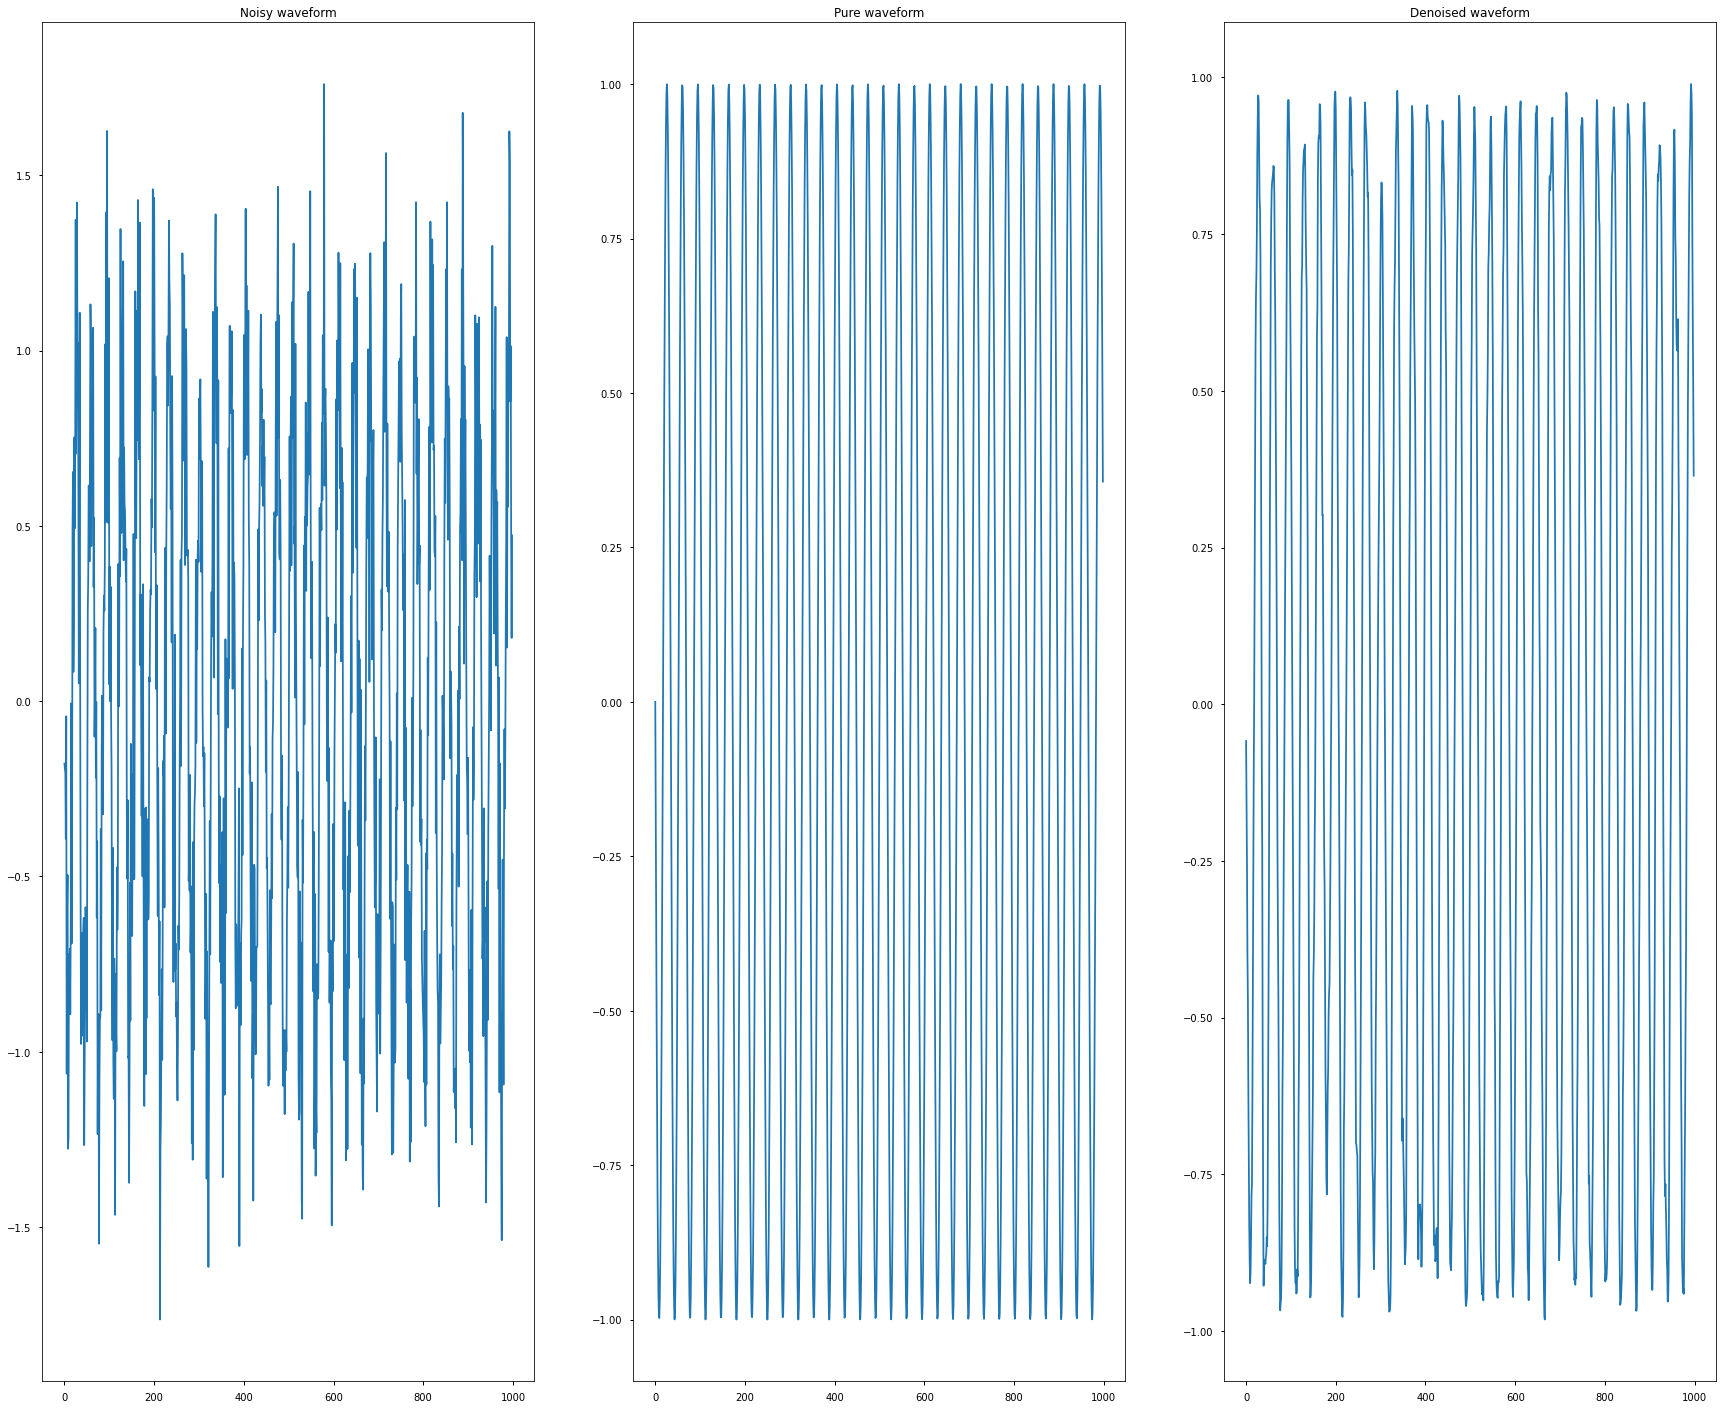

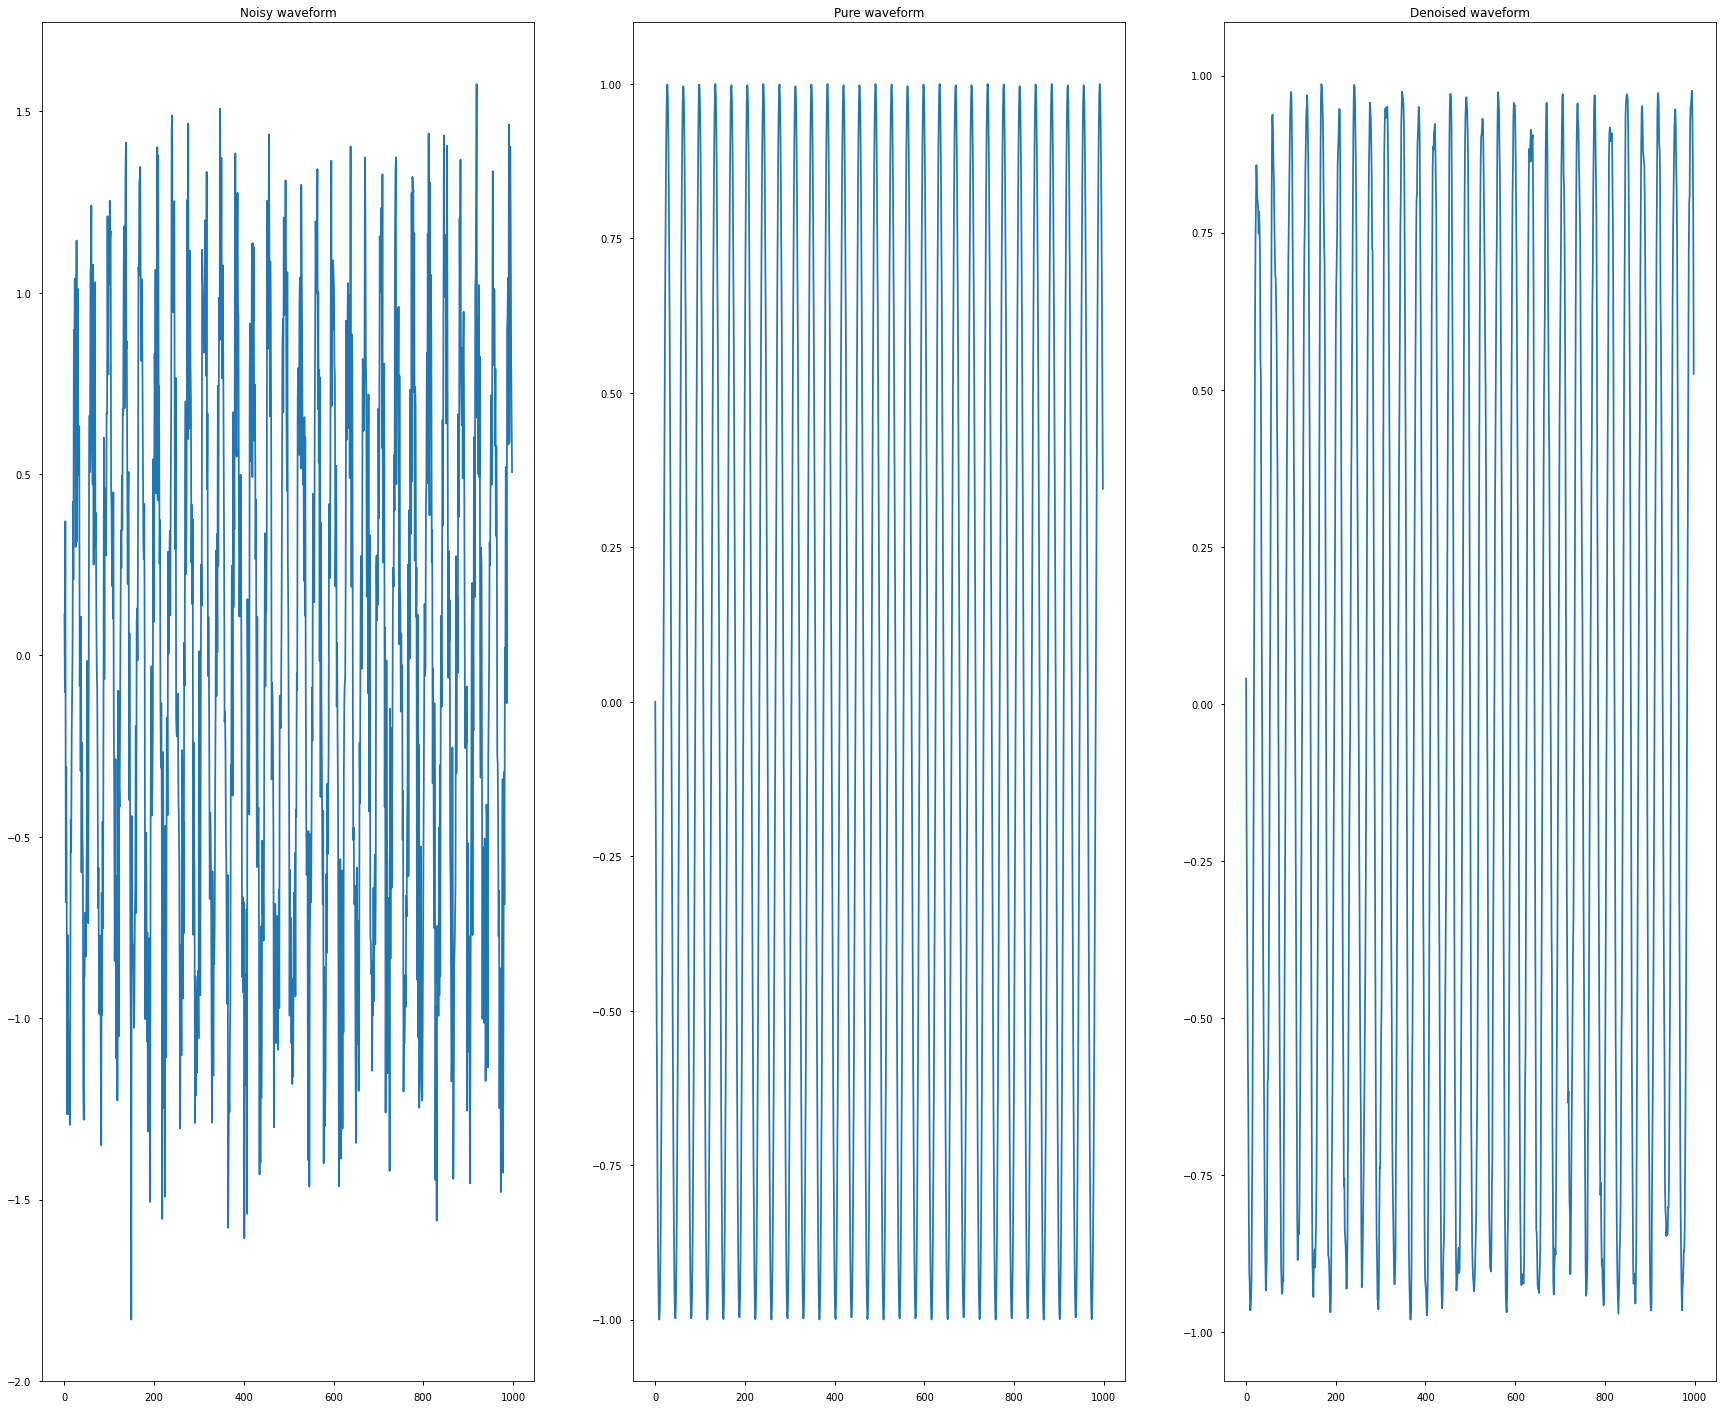

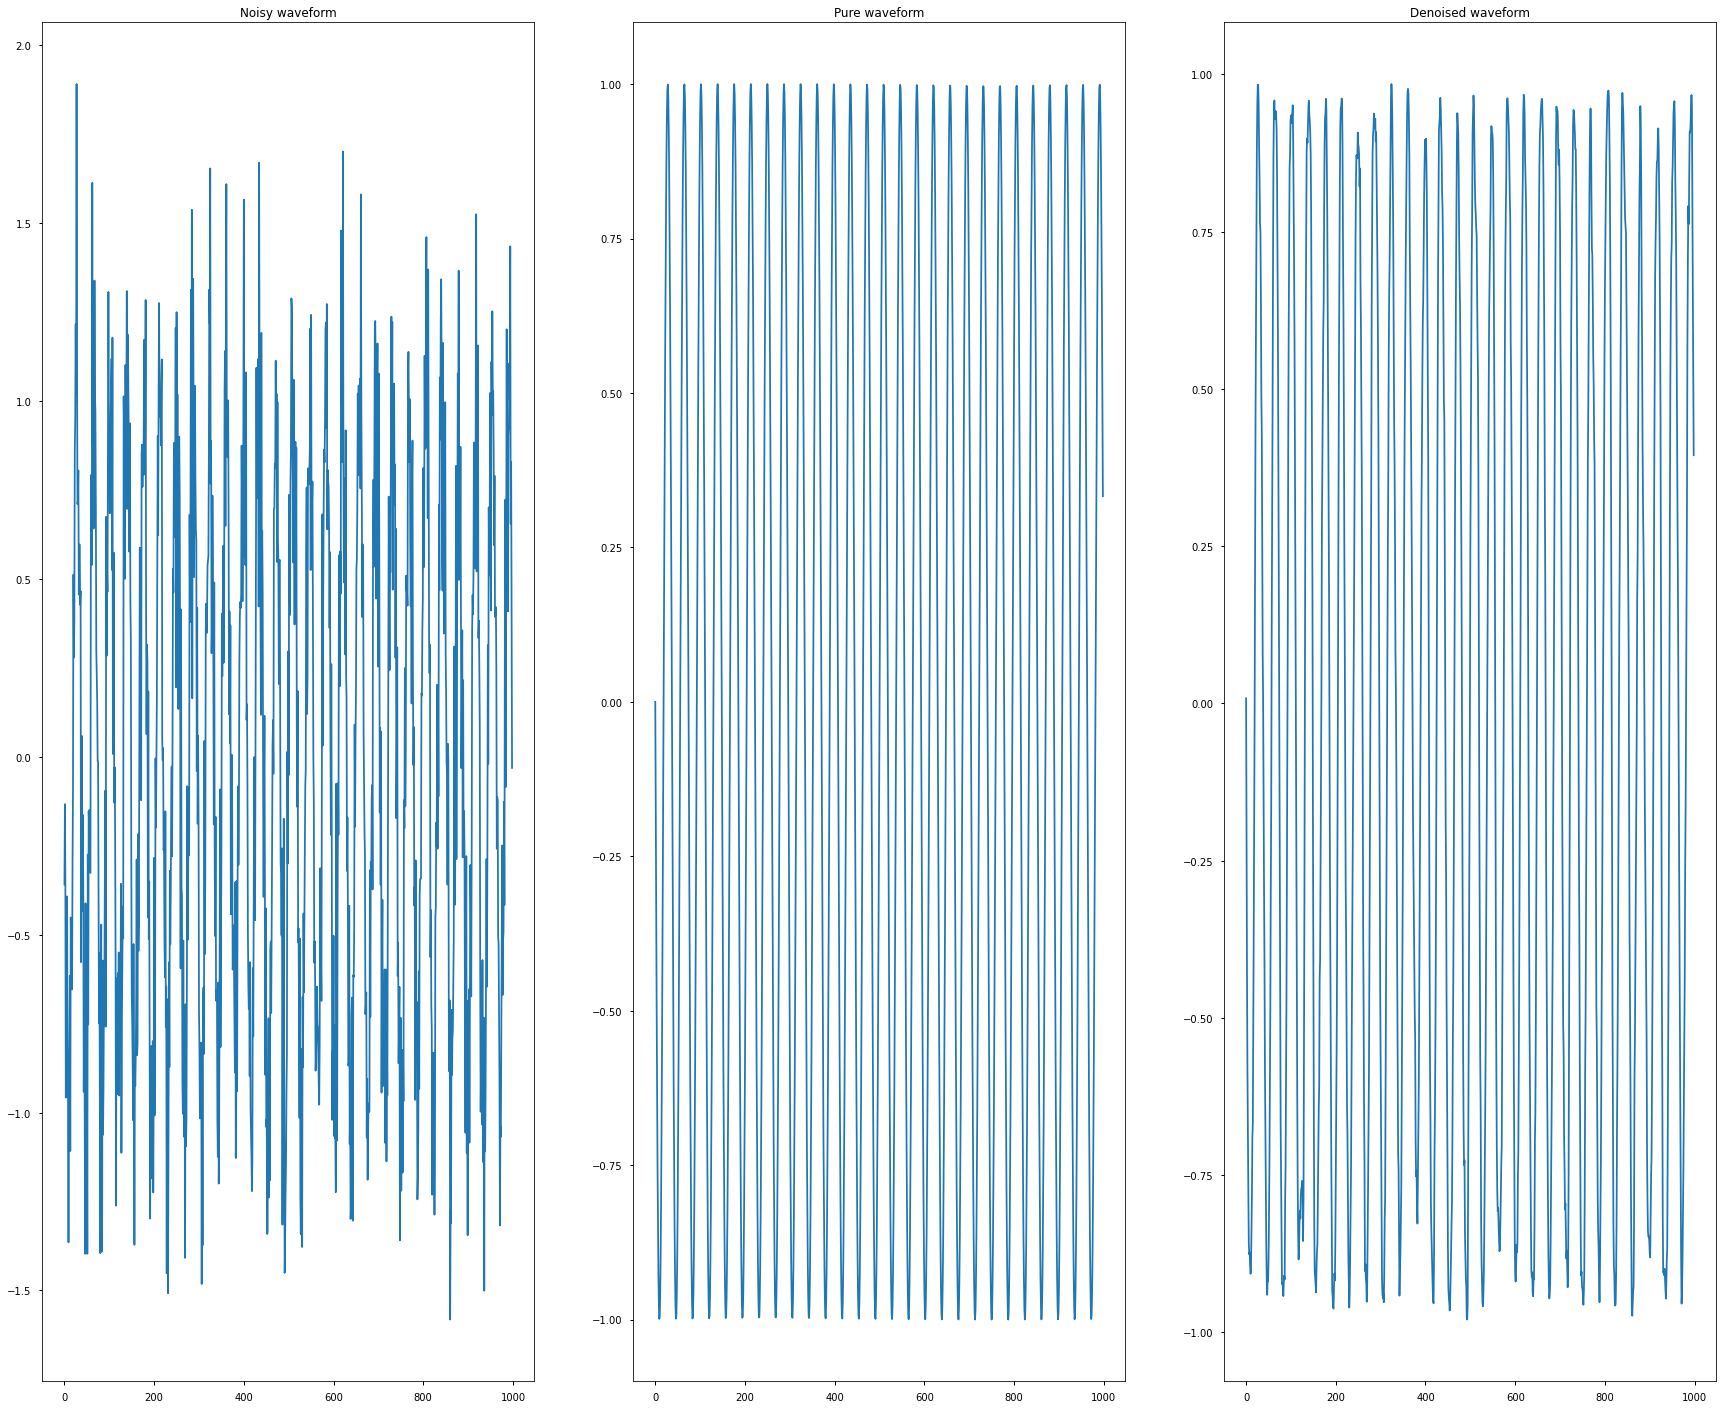

In [13]:
# Plot reconstructions
for i in np.arange(1, num_reconstructions):
  # Prediction index
  prediction_index = i + percentage_training
  # Get the sample and the reconstruction
  original = y_val_noisy[prediction_index]
  pure = y_val_pure[prediction_index]
  reconstruction = np.array(reconstructions[i])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3, figsize=(30,25))
  # Plot sample and reconstruciton
  axes[0].plot(original)
  axes[0].set_title('Noisy waveform')
  axes[1].plot(pure)
  axes[1].set_title('Pure waveform')
  axes[2].plot(reconstruction)
  axes[2].set_title('Denoised waveform')
  plt.show()

In [14]:
num_elements = 2*np.pi
interval_per_element = (2*np.pi)/1000
total_num_elements = int(num_elements / interval_per_element)
starting_point=0

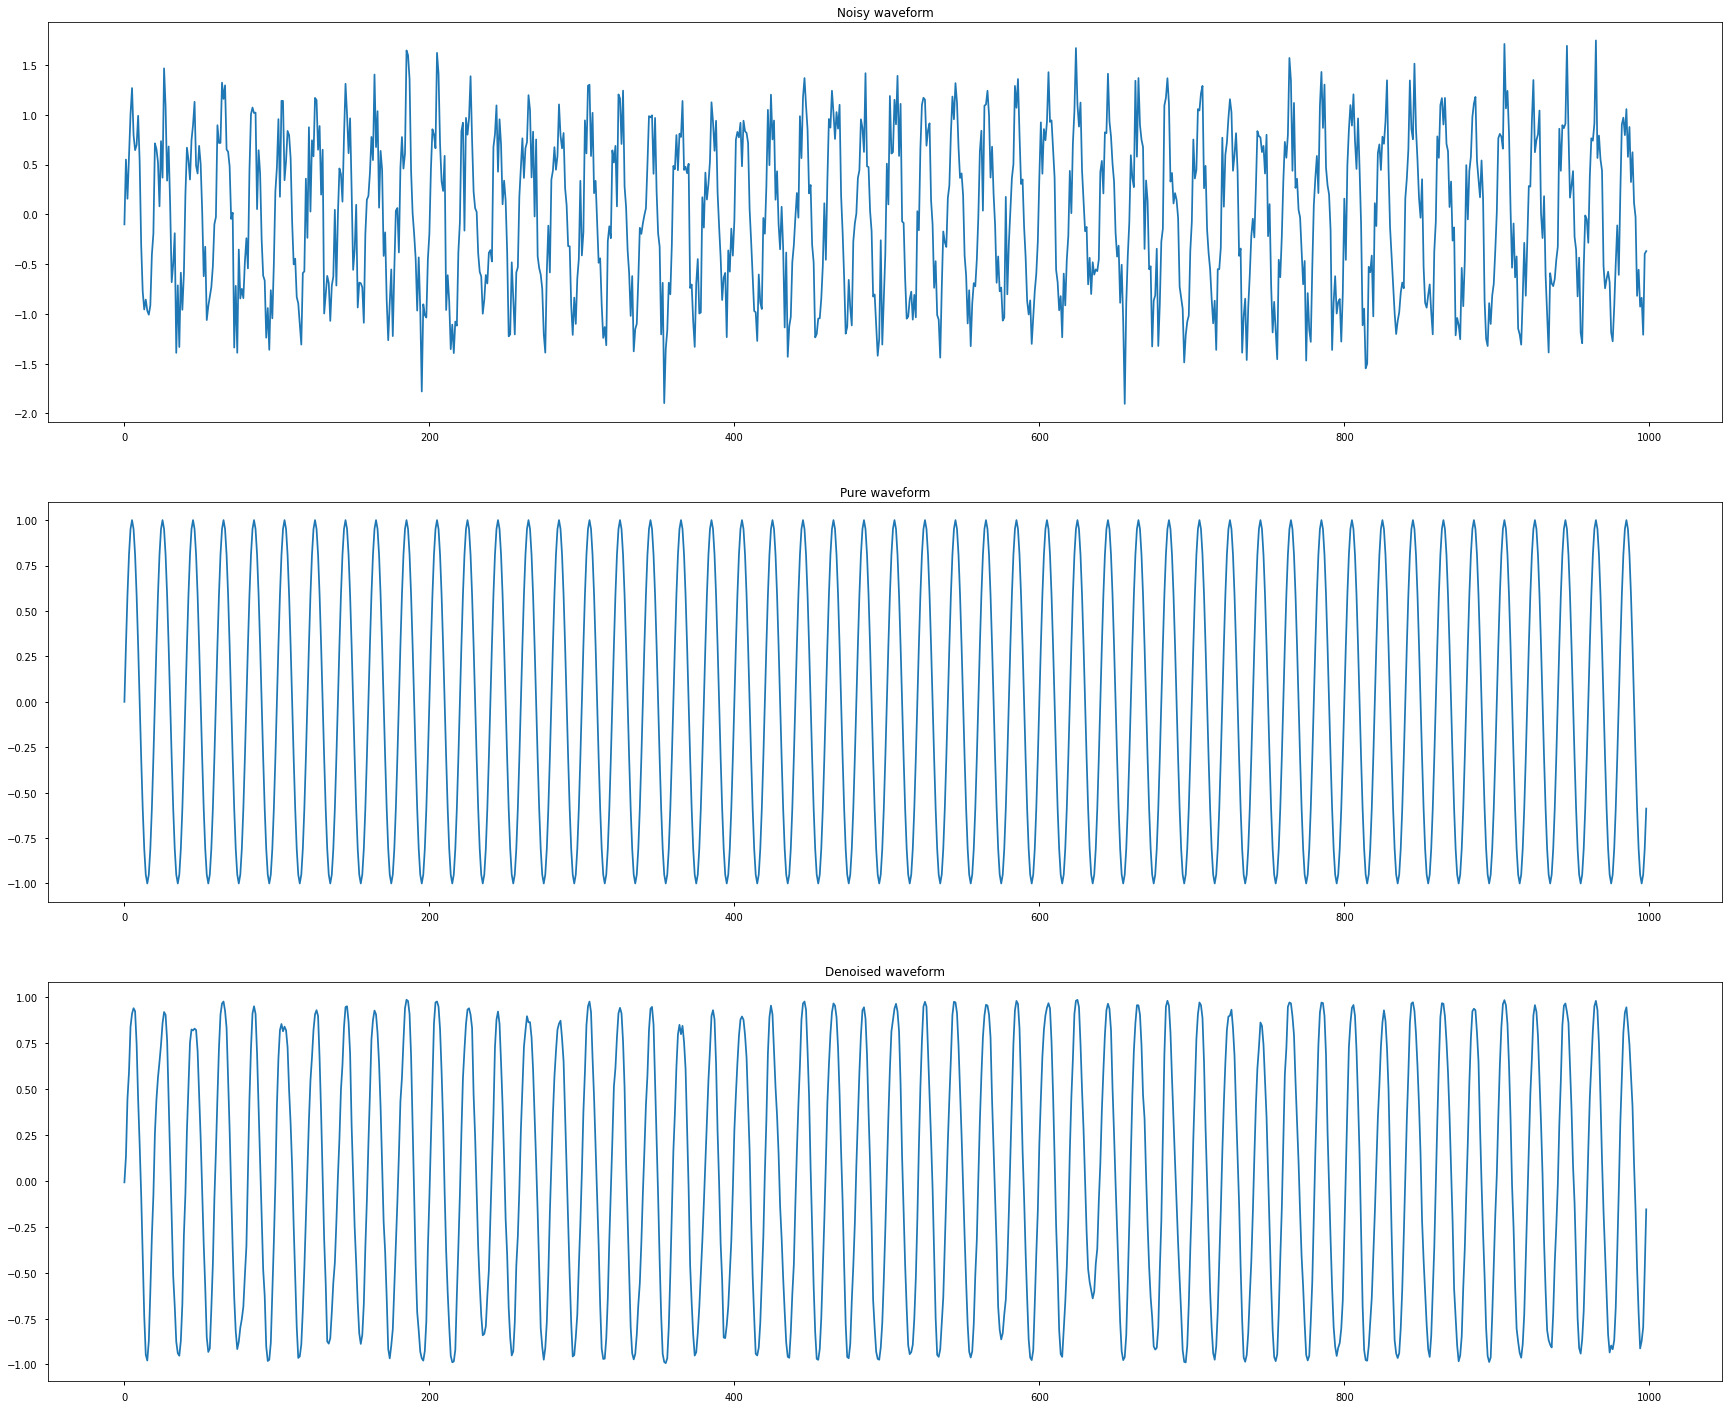

7.9287036905991615
15.166421086708988
0.2525959014892578


In [15]:
#Inside the band

xs = []
ys = []

temp1 = 50

for i in range(starting_point, total_num_elements):
  x_val = i*(interval_per_element) 
  y_val = np.sin(x_val * temp1)
  xs.append(x_val)
  ys.append(y_val)

ys = np.array(ys)

noise_factor = 0.3

pure = ys
noise = np.random.normal(0, 1, pure.shape)
signal = pure + noise_factor * noise

noisy_samples_test = np.array(signal)

noisy_samples_test = noisy_samples_test.reshape(1,999,1)

startTime = time.time()

reconstruction = model.predict(noisy_samples_test)

stopTime = time.time()

timeTaken = stopTime - startTime

reconstruction = reconstruction[0,:,0]

fig, axes = plt.subplots(3, 1, figsize=(30,25))
axes[0].plot(signal)
axes[0].set_title('Noisy waveform')
axes[1].plot(pure)
axes[1].set_title('Pure waveform')
axes[2].plot(reconstruction)
axes[2].set_title('Denoised waveform')
plt.show()

# Input SNR

print(snr(signal,pure))

# Output SNR

print(snr(reconstruction,pure))

# Time Taken:

print(timeTaken)

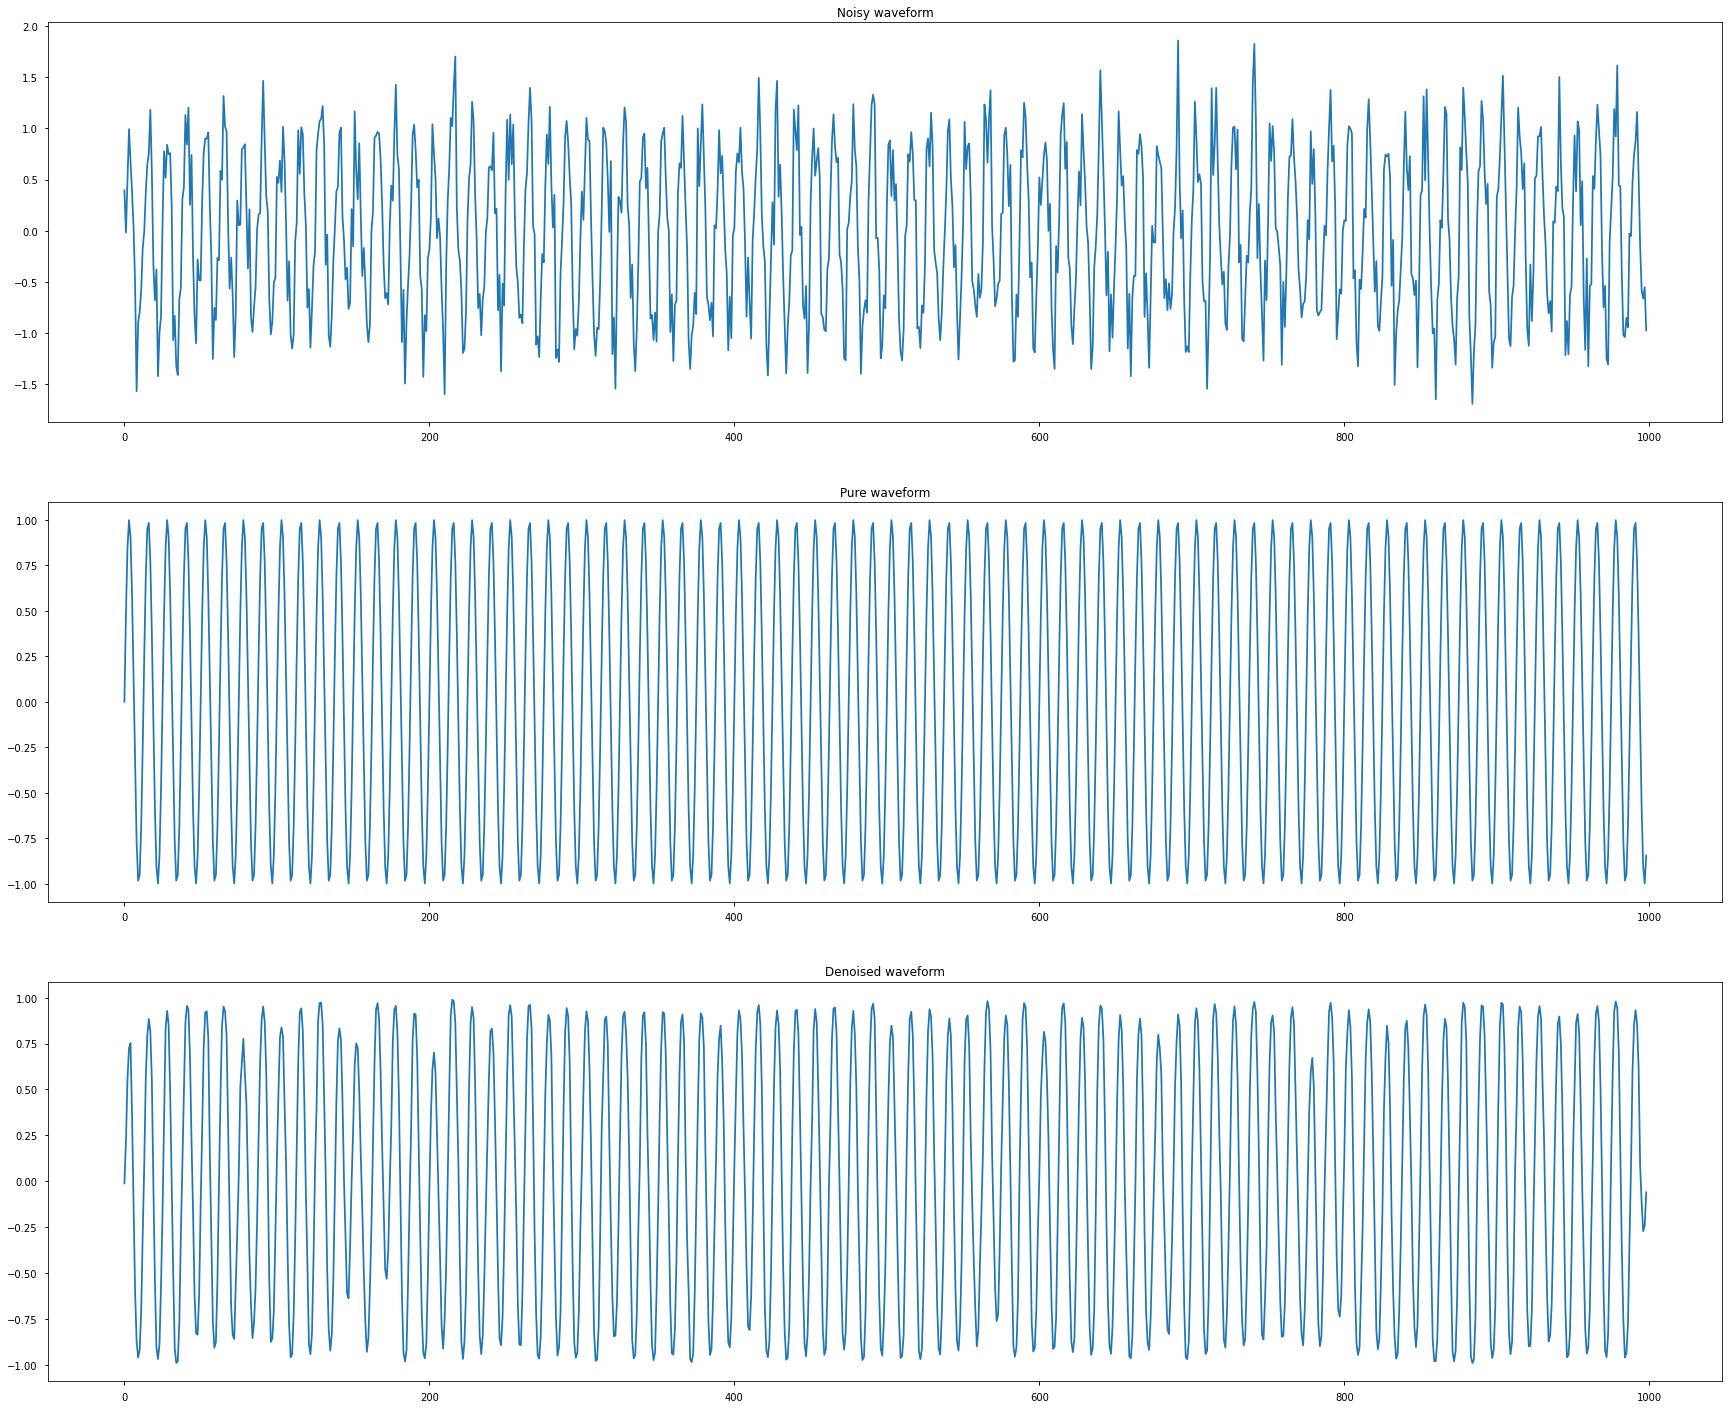

8.00648650850212
13.767099777620086
0.22421622276306152


In [16]:
#After the band

xs = []
ys = []

temp1 = 80

for i in range(starting_point, total_num_elements):
  x_val = i*(interval_per_element) 
  y_val = np.sin(x_val * temp1)
  xs.append(x_val)
  ys.append(y_val)

ys = np.array(ys)

noise_factor = 0.3

pure = ys
noise = np.random.normal(0, 1, pure.shape)
signal = pure + noise_factor * noise

noisy_samples_test = np.array(signal)

noisy_samples_test = noisy_samples_test.reshape(1,999,1)

startTime = time.time()

reconstruction = model.predict(noisy_samples_test)

stopTime = time.time()

timeTaken = stopTime - startTime

reconstruction = reconstruction[0,:,0]

fig, axes = plt.subplots(3, 1, figsize=(30,25))
axes[0].plot(signal)
axes[0].set_title('Noisy waveform')
axes[1].plot(pure)
axes[1].set_title('Pure waveform')
axes[2].plot(reconstruction)
axes[2].set_title('Denoised waveform')
plt.show()

# Input SNR

print(snr(signal,pure))

# Output SNR

print(snr(reconstruction,pure))

# Time Taken:

print(timeTaken)

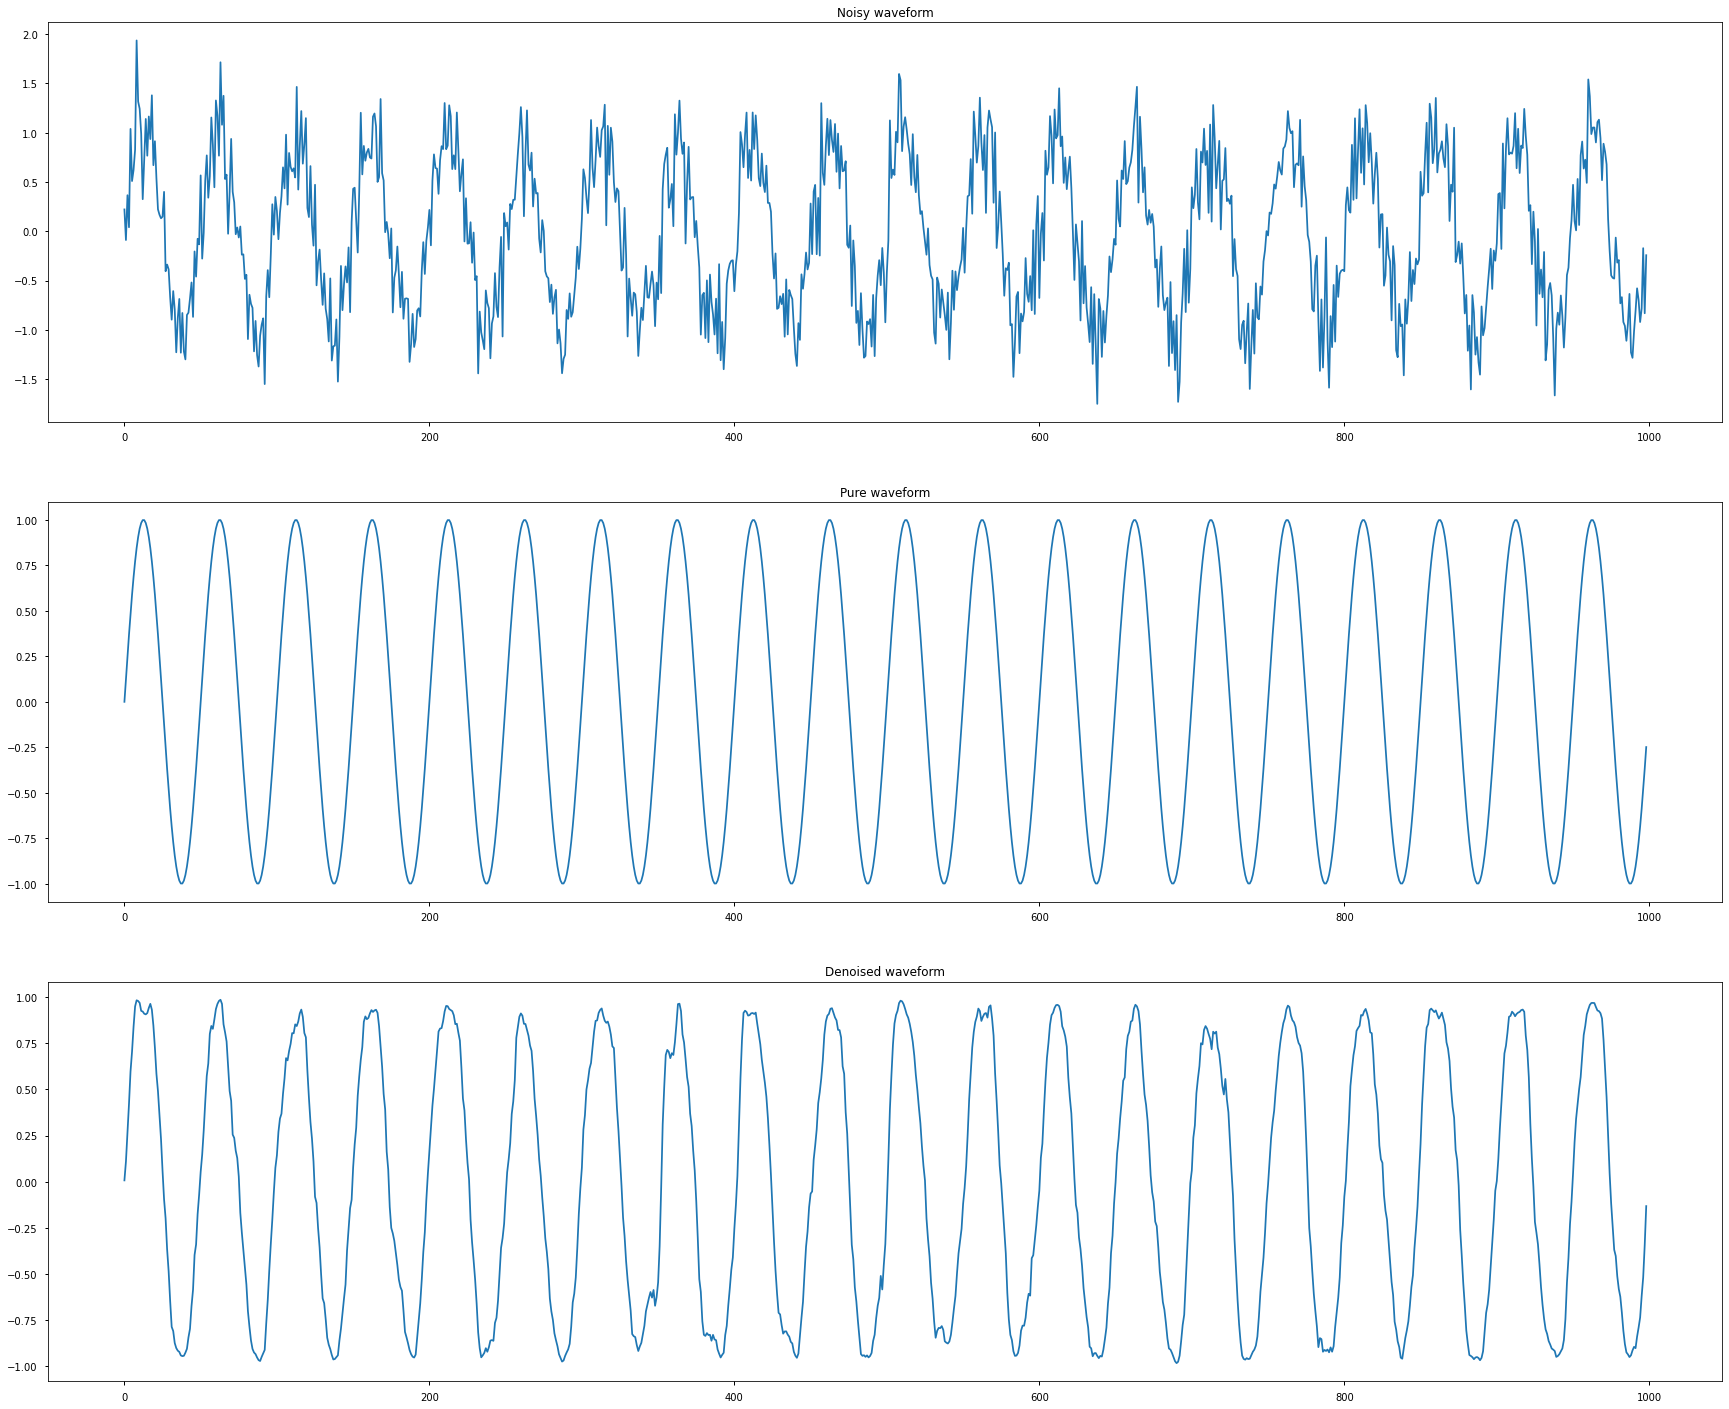

7.998172899811266
16.047404776391957
0.24348926544189453


In [17]:
#Before the band

xs = []
ys = []

temp1 = 20

for i in range(starting_point, total_num_elements):
  x_val = i*(interval_per_element) 
  y_val = np.sin(x_val * temp1)
  xs.append(x_val)
  ys.append(y_val)

ys = np.array(ys)

noise_factor = 0.3

pure = ys
noise = np.random.normal(0, 1, pure.shape)
signal = pure + noise_factor * noise

noisy_samples_test = np.array(signal)

noisy_samples_test = noisy_samples_test.reshape(1,999,1)

startTime = time.time()

reconstruction = model.predict(noisy_samples_test)

stopTime = time.time()

timeTaken = stopTime - startTime

reconstruction = reconstruction[0,:,0]

fig, axes = plt.subplots(3, 1, figsize=(30,25))
axes[0].plot(signal)
axes[0].set_title('Noisy waveform')
axes[1].plot(pure)
axes[1].set_title('Pure waveform')
axes[2].plot(reconstruction)
axes[2].set_title('Denoised waveform')
plt.show()

# Input SNR

print(snr(signal,pure))

# Output SNR

print(snr(reconstruction,pure))

# Time Taken:

print(timeTaken)

In [18]:
#Combination

xs = []
ys = []

temp1 = 50
temp2 = 15

for i in range(starting_point, total_num_elements):
  x_val = i*(interval_per_element) 
  y_val_1 = np.sin(x_val * temp1)
  y_val_2 = np.sin(x_val * temp2)
  ys.append(0.5*y_val_1 + 0.5*y_val_2)

ys = np.array(ys)

noise_factor = 0.3

pure = ys
noise = np.random.normal(0, 1, pure.shape)
signal = pure + noise_factor * noise

noisy_samples_test = np.array(signal)

noisy_samples_test = noisy_samples_test.reshape(1,999,1)

startTime = time.time()

reconstruction = model.predict(noisy_samples_test)

stopTime = time.time()

timeTaken = stopTime - startTime

reconstruction = reconstruction[0,:,0]

fig, axes = plt.subplots(3, 1, figsize=(30,25))
axes[0].plot(signal)
axes[0].set_title('Noisy waveform')
axes[1].plot(pure)
axes[1].set_title('Pure waveform')
axes[2].plot(reconstruction)
axes[2].set_title('Denoised waveform')
plt.show()

# Input SNR

print(snr(signal,pure))

# Output SNR

print(snr(reconstruction,pure))

# Time Taken:

print(timeTaken)

5.316088306230842
10.362273769491267
0.38930320739746094
